## Optimize the Cost on OpenAI API Calls Usage

In [ ]:
!pip install langchain
!pip install openai
!pip install sqlalchemy
!pip install python-dotenv
!pip install pymysql

### 1. Caching
Caching in LLMs (Large Language Models) is a technique for storing the responses to common prompts and queries, so that they can be retrieved quickly and easily without having to call the LLM again and again. This can significantly improve the performance and cost-effectiveness of LLM-powered applications.

There are two main types of caching in LLMs:

***Exact match cache***

An exact match cache stores the results of previous LLM queries, and returns the cached result if the current query is an exact match. This is a simple and effective approach, but it has a low cache hit rate, because LLM queries are often complex and varied.

**Embedding similarity cache**

An embedding similarity cache uses embedding vectors to represent queries and responses. When a new query is received, its embedding vector is calculated and compared to the embedding vectors of all cached responses. The response with the most similar embedding vector is returned to the user.

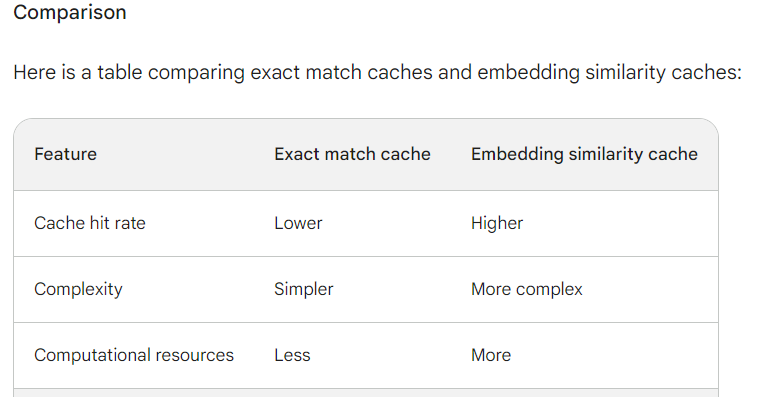

### a) In Memory Cache
Cache that stores things in memory.

In [ ]:
import openai
import langchain
import os
from langchain.cache import InMemoryCache
from langchain.llms import OpenAI
from dotenv import load_dotenv


load_dotenv('/content/drive/MyDrive/vars.env')
os.environ["OPENAI_API_KEY"] = os.getenv('api_key')


In [ ]:
langchain.llm_cache = InMemoryCache()
llm = OpenAI(model_name="text-davinci-002", n=1, best_of=1, cache=True, max_tokens=50)
llm("Tell me a joke")

'\n\nTwo guys stole a calendar. They got six months each.'

In [ ]:
llm("Tell me a joke")

'\n\nTwo guys stole a calendar. They got six months each.'

### b) SQL Alchemy Cache
Cache that uses SQAlchemy as a backend.

In [ ]:
from langchain.cache import SQLAlchemyCache
from sqlalchemy import create_engine
from sqlalchemy.orm import declarative_base
from sqlalchemy import Column, Integer, Text
from urllib.parse import quote_plus

from langchain.llms import OpenAI

Base = declarative_base()

class FulltextLLMCache(Base):
    __tablename__ = "llm_cache_full_text"
    id = Column(Integer, primary_key=True)
    prompt = Column(Text, nullable=False)
    llm = Column(Text, nullable=False)
    idx = Column(Integer)
    response = Column(Text)

load_dotenv()

user = os.getenv('user_name')
password = quote_plus(os.getenv('password'))
endpoint_url = os.getenv('endpoint_url')
database = os.getenv('database')
os.environ["OPENAI_API_KEY"] = os.getenv('api_key')


In [ ]:
# Database URI
db_uri = f"mysql+pymysql://{user}:{password}@{endpoint_url}/{database}"

cache_engine = create_engine(db_uri, pool_recycle=240, pool_size=20, max_overflow=30)

# Assigning to llm_cache
langchain.llm_cache = SQLAlchemyCache(cache_engine, FulltextLLMCache)

llm = OpenAI(model_name="text-davinci-003", n=1, best_of=1,max_tokens=50,  cache=True)


In [ ]:
while True:
    user_input = input("Ask me your question => ")
    response= llm(user_input)
    print(response)

Ask me your question => Who is the Prime minister of India?


The Prime Minister of India is Narendra Modi.
Ask me your question => Who is the prime Minister of Pakistan?


The Prime Minister of Pakistan is Imran Khan.
Ask me your question => Who is the Prime minister of India?


The Prime Minister of India is Narendra Modi.


KeyboardInterrupt: ignored

### 2. Batching
If you are sending multiple requests to the same endpoint, you can batch the prompts to be sent in the same request. This will reduce the number of requests you need to make. The prompt parameter can hold up to 20 unique prompts.

### Example without batching

In [ ]:
import openai
openai.api_key=os.getenv('api_key')
num_stories = 5
prompt = "Once upon a time,"

# serial example, with one story completion per request
for _ in range(num_stories):
    response = openai.Completion.create(
        model="text-davinci-003",
        prompt=prompt,
        max_tokens=20,
    )
    # print story
    print(prompt + response.choices[0].text)

### Example with batching

In [ ]:
import openai  # for making OpenAI API requests


num_stories = 5
prompts = ["Once upon a time,"] * num_stories

# batched example, with 10 story completions per request
response = openai.Completion.create(
    model="text-davinci-003",
    prompt=prompts,
    max_tokens=20,
)

# match completions to prompts by index
stories = [""] * len(prompts)
for choice in response.choices:
    stories[choice.index] = prompts[choice.index] + choice.text

# print stories
for story in stories:
    print(story)
    print("##############")